In [9]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MultipleLocator # for minor ticks
from matplotlib import gridspec
from matplotlib import patches

import numpy as np

from scipy import signal # for convolution
import scipy.stats as scstats
import scipy.special as sps

import pickle
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)

import sys
sys.path.append("../..")

from neuroprob.utils import stats, tools, neural_utils, field_passes
import neuroprob.models as mdl

from tqdm.notebook import tqdm

dev = tools.PyTorch()

plt.style.use(['paper.mplstyle'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
PyTorch version: 1.6.0+cu101
Using device: cuda:0


### Data loading

In [5]:
### Real data ###
sample_bin, track_samples, x_t, y_t, s_t, dir_t, hd_t, eeg_t, theta_t, \
    hilbert_amp, hilbert_theta, pause_ind, pause_size, \
    sep_t_spike, clu_id, t_spike, spike_samples, units, \
    shank_id, local_clu, FR_waveshape, SpkWidthC, \
    refract_viol, isolation_dist, \
    left_x, right_x, bottom_y, top_y = pickle.load(open('../data/datasets/hc5_13.p', 'rb'))

In [2]:
### Toy data ###
sample_bin, track_samples, x_t, y_t, s_t, hd_t, theta_t, dir_t, \
    sep_t_spike, spike_samples, units, \
    left_x, right_x, bottom_y, top_y = pickle.load(open('../data/gauss_pop_IPP.p', 'rb'))

pause_ind = []
pause_size = []

In [6]:
max_speed = s_t.max()
wrap_theta_t = tools.WrapPi(theta_t, True)
arena_width = right_x - left_x
arena_height = top_y - bottom_y

grid_size = (int(arena_width/2), int(arena_height/2))
grid_shape = (left_x, right_x, bottom_y, top_y)

### Model selection

In [420]:
# Fit to subset of neurons
unit_used = [0, 2]#[30, 40, 50]#
units_used = len(unit_used)
used_t_spike = [sep_t_spike[u] for u in unit_used]
behav_data = (x_t, y_t, wrap_theta_t)

binnings = 10
folds = 5

bin_size = 1
tbin, _, rc_t, _ = neural_utils.BinTrain(bin_size, sample_bin, used_t_spike, track_samples)
fit_set, valid_set = neural_utils.SpikeTrainCV(folds, used_t_spike, track_samples, behav_data)
cv_set = []
for f, v in zip(fit_set, valid_set):
    _, v_size, v_spk, _ = \
            neural_utils.BinTrain(bin_size, sample_bin, v[0], len(v[1][0]), _)
    cv_set.append((f[1], f[0], v[1], v_spk, v_size))
    
def rate_func(behav_tuple, bins_tuple, spiketimes):
    rate, prob = neural_utils.IPP_model(sample_bin, behav_tuple, bins_tuple, spiketimes)
    bins = (prob > 0).sum()
    return rate, bins*units_used
    
AIC = np.empty((binnings))
BIC = np.empty((binnings))
nll = np.empty((binnings))
CVs = np.empty((binnings, folds))

shape = np.ones(units_used)
renewal_dist = mdl.renewal.Gamma(units_used, 'identity', shape)

for k in range(binnings):
    bins_x, bins_y = prms.bin_params(k, arena_height, arena_width)
    bins_theta = 1
    
    bin_x = np.linspace(left_x, right_x+1e-3, bins_x+1)
    bin_y = np.linspace(bottom_y, top_y+1e-3, bins_y+1)
    bin_theta = np.linspace(0, 2*np.pi+1e-3, bins_theta+1)
    
    model = mdl.nonparametrics.hist_GLM((bin_x, bin_y, bin_theta), neurons=units_used)
    model.set_params(tbin)
    
    glm = mdl.inference.nll_optimized(model, renewal_dist)
    glm.to(dev)
    
    AIC[k], BIC[k], nll[k], CVs[k] = \
        neural_utils.eval_hist_model(glm, tbin, rate_func, cv_set, behav_data, model.bins_cov, rc_t, used_t_spike)

NameError: name 'prms' is not defined

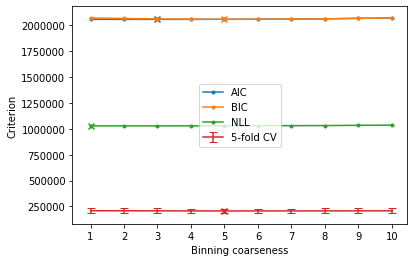

In [17]:
b = np.arange(1, binnings+1)
CV_mean = CVs.mean(1)
CV_std = CVs.std(1)

plt.plot(b, AIC, label='AIC', marker='.')
plt.plot(b, BIC, label='BIC', marker='.')
plt.plot(b, nll, label='NLL', marker='.')
plt.errorbar(b, CV_mean, yerr=CV_std, capsize=4, label='{}-fold CV'.format(folds))

plt.scatter(b[np.argmin(AIC)], np.min(AIC), marker='x')
plt.scatter(b[np.argmin(BIC)], np.min(BIC), marker='x')
plt.scatter(b[np.argmin(nll)], np.min(nll), marker='x')
plt.scatter(b[np.argmin(CV_mean)], np.min(CV_mean), marker='x')

plt.xlabel('Binning coarseness')
plt.ylabel('Criterion')
plt.xticks(b)
plt.legend()
plt.show()


In [63]:
print(sp_rate.shape)

(103, 30, 24)


### Spiking unit characterization

In [7]:
# binning of covariates and analysis
bins_hd = 60
bins_dir = 8
bins_s = 100
bins_x = 30
bins_y = int(arena_height/arena_width*bins_x)
bins_theta = 30

bin_x = np.linspace(left_x, right_x+1e-3, bins_x+1)
bin_y = np.linspace(bottom_y, top_y+1e-3, bins_y+1)
bin_hd = np.linspace(0, 2*np.pi+1e-3, bins_hd+1)
bin_s = np.linspace(0, max_speed+1e-3, bins_s+1)
bin_dir = np.linspace(0, 2*np.pi+1e-3, bins_dir+1)
bin_theta = np.linspace(0, 2*np.pi+1e-3, bins_theta+1)

corr_t_spikes = neural_utils.IPP_threshold(sample_bin, 0.25, (x_t, y_t), (bin_x, bin_y), sep_t_spike)
sp_MI, sp_prob, sp_rate = neural_utils.spike_var_MI(sample_bin, (x_t, y_t), (bin_x, bin_y), corr_t_spikes)

hd_MI, hd_prob, hd_rate = neural_utils.spike_var_MI(sample_bin, (hd_t,), (bin_hd,), sep_t_spike)
s_MI, s_prob, s_rate = neural_utils.spike_var_MI(sample_bin, (s_t,), (bin_s,), sep_t_spike)
dir_MI, dir_prob, dir_rate = neural_utils.spike_var_MI(sample_bin, (dir_t,), (bin_dir,), sep_t_spike)

sm_size = 5
sm_filter = np.ones((sm_size, sm_size)) / sm_size**2
smth_rate = neural_utils.smooth_hist(sp_rate, sm_filter, ['repeat', 'repeat'], dev=dev)
coherence, sparsity = neural_utils.geometric_tuning(sp_rate, smth_rate, sp_prob)

delta_bin_hd = bin_hd[1] - bin_hd[0]
delta_bin_dir = bin_dir[1] - bin_dir[0]
delta_bin_s = bin_s[1] - bin_s[0]
delta_bin_x = bin_x[1] - bin_x[0]
delta_bin_y = bin_y[1] - bin_y[0]

In [ ]:
x, y, omega_p, _, _, _, _, modamp_p = neural_utils.theta_fit(sample_bin, ISI[:10], dev=dev)
unit = 0
plt.plot(x, y[unit])
plt.show()

corr_eeg, fit_eeg, omega_eeg, tau_eeg, power_decay = \
    neural_utils.EEG_fit(sample_bin, eeg_t, lag_range=1250, time_window=1000000, lr=1e-3, dev=dev)

plt.plot(corr_eeg)
plt.plot(fit_eeg)
plt.show()

print(2*np.pi/omega_eeg) #0.1368731546016358

/var/home/dl543/.local/lib/python3.6/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


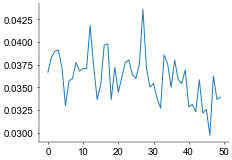

[ 2.73258691  2.01056755  1.15946251  3.17168927  1.12418965  1.62299931
  1.8350422   1.74180231  2.61001079  4.09380124  2.30278188  1.41607902
 14.61272048  1.84852408  2.38988447  1.92970473  5.11970759  2.38065584
 11.39503137  2.05392738  1.88674475  1.52895042  1.25710193  1.19284029
  1.68800148  6.03662914  1.87176064  1.55902305  2.70834964  3.96565719
  2.37581539  2.0586153   1.77055118  8.1501058   3.85989639  2.28424963
  1.80463655  1.28042152  1.20908244  2.8287      1.95411959  2.20343328
  2.8124991   1.68673034  5.05180209  1.29605944  3.50795231  6.42168269
  7.47620301  3.37715911  3.27388969  6.0713901   4.08404593  3.79401713
  4.70297535  1.50788826  2.66163197  2.00823485  1.44814721  7.04777696
  4.98647642  2.53658967  2.33799244  4.88420704  2.1168348   7.90722144
  2.16126998  3.37645401  1.67041923  2.93816162  2.43347696  2.69172138
  3.53630919  1.13262717  4.40545685  1.84362738  3.1556294   2.99693312
  1.35477071  1.33805355  2.33431714  8.50975676  1

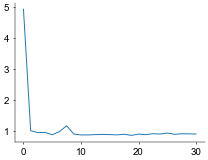

In [423]:
# Organization of cell assemblies in the hippocampus
corr, (freq, fourierTransform), theta_period, theta_index = neural_utils.theta_CCG(sample_bin, sep_t_spike[:], track_samples, dev=dev)

plt.plot(corr[:, 2, 1])
plt.show()
print(theta_index)

plt.plot(freq, np.abs(fourierTransform[:, 6]))
plt.show()

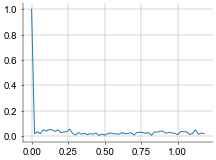

[0.00000000e+00 1.66666667e-02 3.33333333e-02 ... 2.49500000e+01
 2.49666667e+01 2.49833333e+01]
[ 0.          0.         23.56666667  0.          0.          0.
  0.          0.          0.          0.        ]


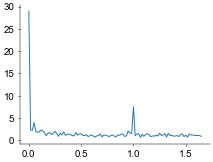

In [430]:
# phase precession
lag = 3000
fac = 50
g = int(np.ceil(theta_t.max()/2./np.pi))
bin_window = g - 101
cbin_theta = np.linspace(0, g*2*np.pi+1e-3, fac*g)
corr, (freq, fourierTransform), precess_index = neural_utils.precess_CCG(sep_t_spike[:10], theta_t, cbin_theta, lag, fac, bin_window, start_points=[0], dev=dev)

n = 0
plt.plot(np.arange(lag)[:60]/fac, corr[:60, n])
plt.grid('on')
plt.show()

plt.plot(freq[:100], np.abs(fourierTransform[:100, n]))
print(freq)
print(precess_index)

In [39]:
bin_x = np.linspace(left_x, right_x+1e-3, bins_x+1)
bin_y = np.linspace(bottom_y, top_y+1e-3, bins_y+1)
bin_hd = np.linspace(0, 2*np.pi+1e-3, bins_hd+1)
bin_s = np.linspace(0, max_speed+1e-3, bins_s+1)
bin_dir = np.linspace(0, 2*np.pi+1e-3, bins_dir+1)
bin_theta = np.linspace(0, 2*np.pi+1e-3, bins_theta+1)

print(var_var_MI(sample_bin, 0.25, x_t, theta_t, bin_x, bin_theta))
print(var_var_MI(sample_bin, 0.25, y_t, theta_t, bin_y, bin_theta))

NameError: name 'theta_index' is not defined

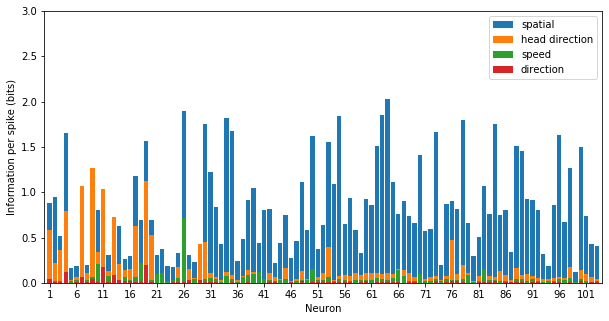

In [254]:
# per cell properties
u = np.arange(1, units+1)

plt.figure(figsize=(10,5))
plt.bar(u, sp_MI, label='spatial', color='tab:blue')
plt.bar(u, hd_MI, label='head direction', color='tab:orange')
plt.bar(u, s_MI, label='speed', color='tab:green')
plt.bar(u, dir_MI, label='direction', color='tab:red')
plt.legend()
plt.xlim(0, units+1)
plt.ylim(0, np.ceil(sp_MI.max()))
plt.xlabel('neuron')
plt.ylabel('information per spike (bits)')
plt.xticks(np.arange(1, units, step=5))

nvars = 4
var = [coherence, sparsity, theta_index, omega_p/(2*np.pi)]
label = ['spatial coherence', 'spatial sparsity', 'theta index', 'theta frequency (Hz)']

for k in range(nvars):
    plt.figure(figsize=(10,3))
    plt.bar(u, var[k])
    plt.xlim(0, units+1)
    plt.ylim(0, np.ceil(var[k].max()))
    plt.xlabel('neuron')
    plt.ylabel(label[k])
    plt.xticks(np.arange(1, units, step=5))

plt.show()

AttributeError: module 'neuroprob.utils.stats' has no attribute 'pearsonr'

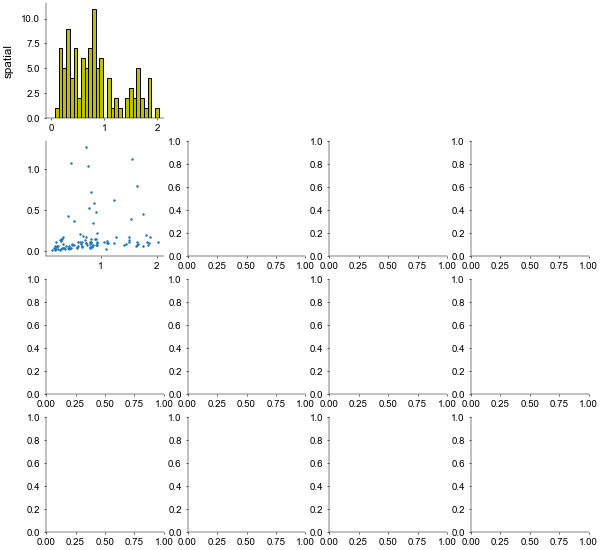

In [224]:
# correlation plots between different cell properties
for r in range(2):
    fig = plt.figure(figsize=(10, 10))
    nvars = 4
    axes = [ fig.add_subplot(nvars, nvars, r * nvars + c + 1) for r in range(0, nvars) for c in range(0, nvars) ]
    if r == 0:
        var = [sp_MI, hd_MI, dir_MI, s_MI]
        label = ['spatial', 'head direction', 'direction', 'speed']
    else:
        var = [sp_MI, coherence, sparsity, theta_index]
        label = ['spatial information', 'spatial coherence', 'spatial sparsity', 'theta index']
        
    for l in range(nvars):
        for k in range(nvars):
            if k < l:
                axes[l*nvars + k].scatter(var[k], var[l], marker='.')
                r, r_p = stats.pearsonr(var[k], var[l]) # Pearson r correlation test
                axes[l*nvars + k].legend(['$r={:.2f}$ ($p={:.2f}$)'.format(r, r_p)])
            elif k == l:
                bins = np.linspace(0, var[l].max()+1e-3, 30)
                axes[l*nvars + l].hist(var[l], bins=bins, edgecolor='k', facecolor='y', linewidth=1)
            else:
                axes[l*nvars + k].set_visible(False)

            if k == 0:
                axes[l*nvars + k].set_ylabel(label[l])
            if l == nvars-1:
                axes[l*nvars + k].set_xlabel(label[k])

    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()



### Spatiotemporal shifts in tuning curves

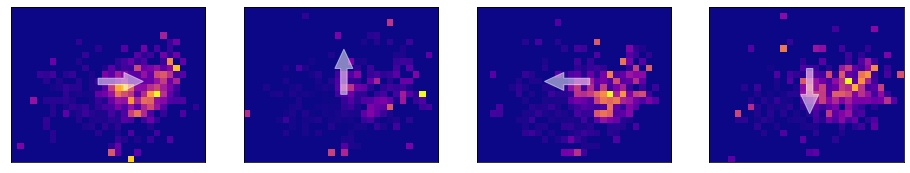

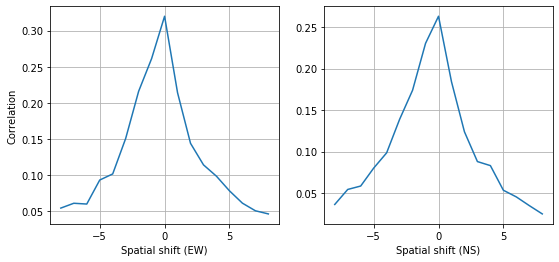

In [188]:
bins_x = 30
bins_y = int(arena_height/arena_width*bins_x)
dir_rate, dir_corr = neural_utils.motion_drift(sample_bin, 8, (dir_t, x_t, y_t), \
                                               np.linspace(left_x, right_x+1e-3, bins_x+1), \
                                               np.linspace(bottom_y, top_y+1e-3, bins_y+1), \
                                              sep_t_spike)

unit = 30
lag = np.arange(-8, 9)
fig = plt.figure(figsize=(16, 4))
nrows = 1
ncols = 4
axes = [ fig.add_subplot(nrows, ncols, r * ncols + c + 1) for r in range(0, nrows) for c in range(0, ncols) ]
for k in range(4):
    tools.draw_2d(np.transpose(dir_rate[unit, k]), origin='lower', cbar_ori=None, aspect='equal', 
                cmap='viridis', vmax=dir_rate[unit, k].max(), ticktitle='firing rate (Hz)', figax=(fig, axes[k]))
    axes[k].set_xticks([])
    axes[k].set_yticks([])
    axes[k].arrow(bins_x/2-2*np.cos(np.pi*k/2), bins_y/2-2*np.sin(np.pi*k/2), 4*np.cos(np.pi*k/2), 4*np.sin(np.pi*k/2), color='w', 
         width=1.0, head_width=2.8, head_length=3.0, alpha=0.5)
      
fig = plt.figure(figsize=(9, 4))
nrows = 1
ncols = 2
axes = [ fig.add_subplot(nrows, ncols, r * ncols + c + 1) for r in range(0, nrows) for c in range(0, ncols) ]
axes[0].plot(lag, dir_corr[unit, 0])
axes[0].set_xlabel('spatial shift (EW)')
axes[0].set_ylabel('correlation')
axes[0].grid()
axes[1].plot(lag, dir_corr[unit, 1])
axes[1].set_xlabel('spatial shift (NS)')
axes[1].grid()

plt.show()

In [5]:
unit_used = [0, 10, 30, 40, 50]#[0, 1, 2, 3, 4]
units_used = len(unit_used)
behav_data = (x_t, y_t, wrap_theta_t)

bins_x = 30
bins_y = int(arena_height/arena_width*bins_x)
bins_theta = 60

bin_x = np.linspace(left_x, right_x+1e-3, bins_x+1)
bin_y = np.linspace(bottom_y, top_y+1e-3, bins_y+1)
bin_theta = np.linspace(0, 2*np.pi+1e-3, bins_theta+1)

bins_tuple = (bin_x, bin_y, bin_theta)

shifts = 101
offset = -50
lag_time = np.arange(offset*10, (offset+shifts)*10, 10)

NLL, CVs = neural_utils.temporal_shift(sample_bin, lag_time, behav_data, bins_tuple, [sep_t_spike[u] for u in unit_used], dev)

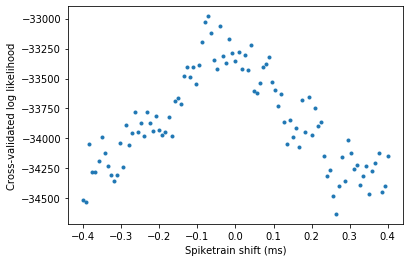

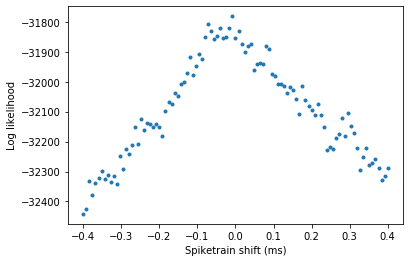

In [12]:
neuron = 0

plt.figure()
#for k in range(5):
#    plt.plot(lag_time*sample_bin, -CVs[:, k, neuron], linestyle='', marker='.')
plt.plot(lag_time*sample_bin, -CVs[:, :, neuron].mean(1), linestyle='', marker='.')
plt.xlabel('Spiketrain shift (ms)')
plt.ylabel('Cross-validated log likelihood')
plt.show()

plt.figure()
plt.plot(lag_time*sample_bin, -NLL[:, neuron], linestyle='', marker='.')
plt.xlabel('Spiketrain shift (ms)')
plt.ylabel('Log likelihood')
plt.show()

In [16]:
sp_rate.shape

(103, 30, 24)

### Cell visualization

In [ ]:
unit = 39

fig = plt.figure(figsize=(8, 3))
nrows = 1
ncols = 2
axes = [ fig.add_subplot(nrows, ncols, r * ncols + c + 1) for r in range(0, nrows) for c in range(0, ncols) ]

fig, ax = tools.draw_2d(np.transpose(sp_rate[unit]), origin='lower', aspect='equal', cbar_size='5%', 
                        cmap='viridis', vmax=sp_rate[unit].max(), ticktitle='', figax=(fig, axes[0]))
tools.decorate_ax(ax)

fig, ax = tools.draw_2d(np.transpose(smth_rate[unit]), origin='lower', aspect='equal', cbar_size='5%', 
                        cmap='viridis', vmax=smth_rate[unit].max(), ticktitle='Firing rate (Hz)', figax=(fig, axes[1]))
tools.decorate_ax(ax)

fig.subplots_adjust(wspace=0.3)

figtr = fig.transFigure.inverted()
ax0tr = axes[0].transAxes
ptB = figtr.transform(ax0tr.transform((1.12, 0.5)))
ptE = figtr.transform(ax0tr.transform((1.23, 0.5)))

arrow = patches.FancyArrowPatch(
    ptB, ptE, transform=fig.transFigure,
    fc = "black", arrowstyle='Wedge', alpha = 1.0,
    mutation_scale = 150.
)
fig.patches.append(arrow)

#plt.savefig('example_smooth.svg')
#plt.savefig('example_smooth.pdf')
plt.show()

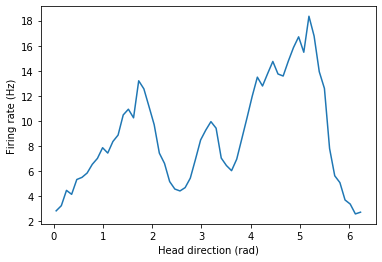

In [53]:
unit = 8
plt.plot(bin_hd[:-1] + delta_bin_hd/2, hd_rate[unit])
plt.xlabel('Head direction (rad)')
plt.ylabel('Firing rate (Hz)')
plt.show()

5


### Spike train dynamics predicts theta related phase precession in hippocampal pyramidal cells

In [ ]:
grid_extent = (left_x, right_x, bottom_y, top_y)

# theta phase map
white = '#ffffff'
black = '#000000'
red = '#ff0000'
blue = '#0000ff'
angle_map = tools.make_cmap([blue, red, blue], 'angle_map')

# phase fields
bins_x = 20
bins_y = int(arena_height/arena_width*bins_x)
behav_data = (x_t, y_t, wrap_theta_t)

bin_x = np.linspace(left_x, right_x+1e-3, bins_x+1)
bin_y = np.linspace(bottom_y, top_y+1e-3, bins_y+1)
spat_bins = (bin_x, bin_y)
theta, mu, var = neural_utils.phase_field(sample_bin, behav_data, spat_bins, sep_t_spike)

neuron = 30
vs.visualize_field_(np.transpose(mu[neuron]), grid_extent, vmax=2*np.pi, cmap=angle_map, 
                    ticks=[0, np.pi, 2*np.pi], ticklabels=[r'$0$', r'$\pi$', r'$2\pi$'], aspect='equal', 
                    ticktitle='circular mean')


vs.visualize_field_(np.transpose(var[neuron]), grid_extent, vmax=1., aspect='equal', ticktitle='circular variance')

plt.show()

In [467]:
# locally weighted likelihood for von Mises
bin_size = 1
tbin, resamples, rc_t, _ = neural_utils.BinTrain(bin_size, sample_bin, sep_t_spike, track_samples)

grid_size = (int(arena_width/10), int(arena_height/10))
grid_shape = [[left_x, right_x], [bottom_y, top_y]]
grid_extent = (left_x, right_x, bottom_y, top_y)

l = [100.0, 100.0]
def kernel_func(x_1, x_2):
    dim = x_1.shape[-1]
    return 1./(np.prod(l) * np.sqrt(2*np.pi)**dim) * np.exp(0.5*(((x_1-x_2)/l)**2).sum(-1))

func = lambda p: neural_utils.LWL_model(p, sample_bin, behav_data, rc_t, kernel_func)

_, mshtpl = tools.compute_mesh(grid_size, grid_shape, func)



neuron = 30
_, ax = vs.visualize_field_(mshtpl[1][0][neuron].T, grid_extent, vmax=2*np.pi, cmap=angle_map, ticktitle='phase')

_, ax = vs.visualize_field_(mshtpl[1][1][neuron].T, grid_extent, cmap=angle_map, ticktitle='modulation')

TypeError: 'float' object is not subscriptable

### Regressor fit

In [ ]:
# Data
unit = [22]#, 40, 50]
units = len(unit)
t_spike = [used_t_spike[u] for u in unit]
behav_tuple = (x_t, y_t, s_t, wrap_theta_t, dir_t, hd_t)

bin_size = 1
tbin, _, rc_t, _ = neural_utils.BinTrain(bin_size, sample_bin, t_spike, track_samples)


In [ ]:
q_cdf = []
q_order = []
p_DS = []
p_KS = []
s_KS = []

In [659]:
# lengthscales of different regressors of population
unit_list = np.arange(50)
euclid = []
toroidal = []

for u in unit_list:
    unit_used = [u]
    units_used = len(unit_used)
    used_t_spike = [sep_t_spike[u] for u in unit_used]
    behav_tuple = (x_t, y_t, s_t, wrap_theta_t, dir_t, hd_t)

    bin_size = 1
    tbin, _, rc_t, _ = neural_utils.BinTrain(bin_size, sample_bin, used_t_spike, track_samples)

    num_induc = 64

    ind_list = [left_x + arena_width*np.random.rand(num_induc), \
                bottom_y + arena_height*np.random.rand(num_induc), \
                np.random.rand(num_induc)*max_speed, \
                np.random.rand(num_induc)*2*np.pi, \
                np.random.rand(num_induc)*2*np.pi, \
                np.random.rand(num_induc)*2*np.pi]

    inducing_points = np.array(ind_list).T

    units_ = 1
    l = np.ones(units_)
    v = np.ones(units_)
    kt = [('RBF', np.array([l, l, l]), v), ('torus_Cos', np.array([l, l, l]), v)]


    glm_rate = mdl.nonparametrics.GP_covariates(units_used, inducing_points, kt,
                                                None, None, link='exp',
                                                mean_ini=np.zeros((1, units_used, 1)))
    glm_rate.set_params(sample_bin)

    shape = np.ones(units_used)
    renewal_dist = mdl.renewal.Gamma(units_used, 'exp', shape)
    renewal_dist.set_params(sample_bin)

    glm = mdl.inference.nll_optimized(glm_rate, renewal_dist)
    glm.preprocess(tuple(b[:3000000] for b in behav_tuple), None, rc_t[:, :3000000], batch_size=100000)
    glm.to(dev)


    # fit
    sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.9)
    opt_tuple = (optim.Adam, 100, sch)
    opt_lr_dict = {'default': 1e-2}
    glm.set_optimizers(opt_tuple, opt_lr_dict)

    annealing = lambda x: min(1.0, 0.01*x)
    glm.fit(1000, margin=1e1, premature=100, anneal_func=annealing, cov_samples=1)

    euclid.append(glm_rate.kernel_.kern0.lengthscale.data.cpu().numpy())
    toroidal.append(glm_rate.kernel_.kern1.lengthscale.data.cpu().numpy())
    
euclid = np.array(euclid)
toroidal = np.array(toroidal)

In [ ]:
place_field = []
lower_s = []
mean_s = []
upper_s = []
lower_th = []
mean_th = []
upper_th = []
lower_dir = []
mean_dir = []
upper_dir = []
lower_hd = []
mean_hd = []
upper_hd = []

In [106]:
place_field = place_field[:-1]
lower_s = lower_s[:-1]
mean_s = mean_s[:-1]
upper_s = upper_s[:-1]
lower_th = lower_th[:-1]
mean_th = mean_th[:-1]
upper_th = upper_th[:-1]
lower_dir = lower_dir[:-1]
mean_dir = mean_dir[:-1]
upper_dir = upper_dir[:-1]
lower_hd = lower_hd[:-1]
mean_hd = mean_hd[:-1]
upper_hd = upper_hd[:-1]

In [108]:
X = [300., 530.]
Y = [200., 210.]

In [109]:
# evaluate tuning
SP = 500.
TH = 0.
DR = 0.
HD = 0.
n = 1


# Place field
grid_size = [int(arena_width/10), int(arena_height/10)]
grid_shape = [[left_x, right_x], [bottom_y, top_y]]
grid_extent = (left_x, right_x, bottom_y, top_y)

def func(pos):
    prevshape = pos.shape[1:]
    x = pos[0].flatten()
    y = pos[1].flatten()
    covariates = np.array([x, y, SP*np.ones_like(x), \
                  TH*np.ones_like(x), DR*np.ones_like(x), HD*np.ones_like(x)])
    return glm_rate.eval_rate(covariates, [0])[0].reshape(*prevshape)

(xx, yy), place_field_ = tools.compute_mesh(grid_size, grid_shape, func)
place_field.append(place_field_)
    
    

# GP tuning
steps= 100

covariates = (X[n]*np.ones(steps), Y[n]*np.ones(steps), np.linspace(0, max_speed, steps), \
              TH*np.ones(steps), DR*np.ones(steps), HD*np.ones(steps))
lower, mean, upper = glm_rate.eval_rate(covariates, [0], False)
lower_s.append(lower[0])
mean_s.append(mean[0])
upper_s.append(upper[0])

covariates = (X[n]*np.ones(steps), Y[n]*np.ones(steps), SP*np.ones(steps), \
              np.linspace(0, 2*np.pi, steps), DR*np.ones(steps), HD*np.ones(steps))
lower, mean, upper = glm_rate.eval_rate(covariates, [0], False)
lower_th.append(lower[0])
mean_th.append(mean[0])
upper_th.append(upper[0])


covariates = (X[n]*np.ones(steps), Y[n]*np.ones(steps), SP*np.ones(steps), \
              TH*np.ones(steps), np.linspace(0, 2*np.pi, steps), HD*np.ones(steps))
lower, mean, upper = glm_rate.eval_rate(covariates, [0], False)
lower_dir.append(lower[0])
mean_dir.append(mean[0])
upper_dir.append(upper[0])


covariates = (X[n]*np.ones(steps), Y[n]*np.ones(steps), SP*np.ones(steps), \
              TH*np.ones(steps), DR*np.ones(steps), np.linspace(0, 2*np.pi, steps))
lower, mean, upper = glm_rate.eval_rate(covariates, [0], False)
lower_hd.append(lower[0])
mean_hd.append(mean[0])
upper_hd.append(upper[0])

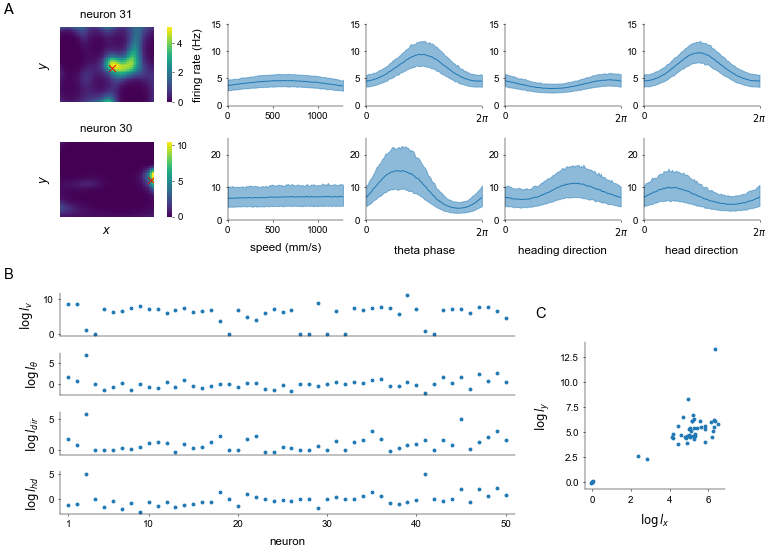

In [115]:
# lengthscales and full tuning example
fig = plt.figure(figsize=(10, 7))

# full tuning plot
widths = [1]
heights = [1, 1]
nrows = 2
ncols = 1
spec_ = fig.add_gridspec(ncols=ncols, nrows=nrows, width_ratios=widths,
                         height_ratios=heights, left=0.0, right=0.16, bottom=0.6, top=1.0)

# Place field
grid_extent = (left_x, right_x, bottom_y, top_y)

ax = fig.add_subplot(spec_[0, 0])
ax.text(-0.08, 1.02, 'A', transform=fig.transFigure, size=15)
_, ax = vs.visualize_field_(place_field[0], grid_extent, ticktitle='', figax=(fig, ax))
#tools.decorate_ax(ax, xlim=[left_x, right_x], ylim=[bottom_y, top_y])
ax.scatter(X[0], Y[0], color='r', marker='x', s=50)
ax.set_ylabel(r'$y$')
ax.set_title(r'neuron 31', fontsize=12, pad=10)

ax = fig.add_subplot(spec_[1, 0])
_, ax = vs.visualize_field_(place_field[1], grid_extent, ticktitle='', figax=(fig, ax))
#tools.decorate_ax(ax, xlim=[left_x, right_x], ylim=[bottom_y, top_y])
ax.scatter(X[1], Y[1], color='r', marker='x', s=50)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_title(r'neuron 30', fontsize=12, pad=10)
    
    

# GP tuning
widths = [1, 1, 1, 1]
heights = [1, 1]
nrows = 2
ncols = 4
spec = fig.add_gridspec(ncols=ncols, nrows=nrows, width_ratios=widths,
                         height_ratios=heights, left=0.24, right=1.0, bottom=0.6, top=1.0)


steps= 100
y_lim = 15.0

c = np.linspace(0, max_speed, steps)
ax = fig.add_subplot(spec[0, 0])
line, = ax.plot(c, mean_s[0])
ax.fill_between(
    c, lower_s[0],
    upper_s[0], color=line.get_color(), alpha=0.5
)
#ax2.scatter(loc_x, loc_rate, marker='.', s=10)

ax.set_ylabel('firing rate (Hz)')
ax.set_xlim(0, max_speed)
ax.set_ylim(0, y_lim)


c = np.linspace(0, 2*np.pi, steps)
ax = fig.add_subplot(spec[0, 1])
line, = ax.plot(c, mean_th[0])
ax.fill_between(
    c, lower_th[0],
    upper_th[0], color=line.get_color(), alpha=0.5
)
#ax2.scatter(loc_x, loc_rate, marker='.', s=10)

ax.set_xlim(0, 2*np.pi)
ax.set_ylim(0, y_lim)
ax.set_xticks([0, 2*np.pi])
ax.set_xticklabels(['0', r'$2\pi$'])


c = np.linspace(0, 2*np.pi, steps)
ax = fig.add_subplot(spec[0, 2])
line, = ax.plot(c, mean_dir[0])
ax.fill_between(
    c, lower_dir[0],
    upper_dir[0], color=line.get_color(), alpha=0.5
)
#ax2.scatter(loc_x, loc_rate, marker='.', s=10)

ax.set_xlim(0, 2*np.pi)
ax.set_ylim(0, y_lim)
ax.set_xticks([0, 2*np.pi])
ax.set_xticklabels(['0', r'$2\pi$'])


c = np.linspace(0, 2*np.pi, steps)
ax = fig.add_subplot(spec[0, 3])
line, = ax.plot(c, mean_hd[0])
ax.fill_between(
    c, lower_hd[0],
    upper_hd[0], color=line.get_color(), alpha=0.5
)
#ax2.scatter(loc_x, loc_rate, marker='.', s=10)

ax.set_xlim(0, 2*np.pi)
ax.set_ylim(0, y_lim)
ax.set_xticks([0, 2*np.pi])
ax.set_xticklabels(['0', r'$2\pi$'])


y_lim = 25.0

c = np.linspace(0, max_speed, steps)
ax = fig.add_subplot(spec[1, 0])
line, = ax.plot(c, mean_s[1])
ax.fill_between(
    c, lower_s[1],
    upper_s[1], color=line.get_color(), alpha=0.5
)
#ax2.scatter(loc_x, loc_rate, marker='.', s=10)

ax.set_xlabel('speed (mm/s)')
#ax.set_ylabel('firing rate (Hz)')
ax.set_xlim(0, max_speed)
ax.set_ylim(0, y_lim)


c = np.linspace(0, 2*np.pi, steps)
ax = fig.add_subplot(spec[1, 1])
line, = ax.plot(c, mean_th[1])
ax.fill_between(
    c, lower_th[1],
    upper_th[1], color=line.get_color(), alpha=0.5
)
#ax2.scatter(loc_x, loc_rate, marker='.', s=10)

ax.set_xlabel('theta phase')
ax.set_xlim(0, 2*np.pi)
ax.set_ylim(0, y_lim)
ax.set_xticks([0, 2*np.pi])
ax.set_xticklabels(['0', r'$2\pi$'])


c = np.linspace(0, 2*np.pi, steps)
ax = fig.add_subplot(spec[1, 2])
line, = ax.plot(c, mean_dir[1])
ax.fill_between(
    c, lower_dir[1],
    upper_dir[1], color=line.get_color(), alpha=0.5
)
#ax2.scatter(loc_x, loc_rate, marker='.', s=10)

ax.set_xlabel('heading direction')
ax.set_xlim(0, 2*np.pi)
ax.set_ylim(0, y_lim)
ax.set_xticks([0, 2*np.pi])
ax.set_xticklabels(['0', r'$2\pi$'])


c = np.linspace(0, 2*np.pi, steps)
ax = fig.add_subplot(spec[1, 3])
line, = ax.plot(c, mean_hd[1])
ax.fill_between(
    c, lower_hd[1],
    upper_hd[1], color=line.get_color(), alpha=0.5
)
#ax2.scatter(loc_x, loc_rate, marker='.', s=10)

ax.set_xlabel('head direction')
ax.set_xlim(0, 2*np.pi)
ax.set_ylim(0, y_lim)
ax.set_xticks([0, 2*np.pi])
ax.set_xticklabels(['0', r'$2\pi$'])



# lengthscales
widths = [1]
heights = [1, 1, 1, 1]
nrows = 4
ncols = 1
spec = fig.add_gridspec(ncols=ncols, nrows=nrows, width_ratios=widths,
                         height_ratios=heights, left=0, right=0.65, bottom=0.0, top=0.45)

x_val = np.arange(1, euclid.shape[0]+1)
ax = fig.add_subplot(spec[0, 0])
ax.text(-0.08, 0.48, 'B', transform=fig.transFigure, size=15)
ax.scatter(x_val, np.log(euclid[:, 2]))
ax.set_xlim(0,51)
ax.set_ylabel(r'$\log\,l_{v}$')
ax.set_xticks([])

ax = fig.add_subplot(spec[1, 0])
ax.scatter(x_val, np.log(toroidal[:, 0]))
ax.set_xlim(0,51)
ax.set_ylabel(r'$\log\,l_{\theta}$')
ax.set_xticks([])

ax = fig.add_subplot(spec[2, 0])
ax.scatter(x_val, np.log(toroidal[:, 1]))
ax.set_xlim(0,51)
ax.set_xticks([])
ax.set_ylabel(r'$\log\,l_{dir}$')

ax = fig.add_subplot(spec[3, 0])
ax.scatter(x_val, np.log(toroidal[:, 2]))
ax.set_xlim(0,51)
ax.set_ylabel(r'$\log\,l_{hd}$')
ax.set_xticks([1,10,20,30,40,50])
ax.set_xlabel('neuron')

widths = [1]
heights = [1]
nrows = 1
ncols = 1
spec = fig.add_gridspec(ncols=ncols, nrows=nrows, width_ratios=widths,
                         height_ratios=heights, left=0.75, right=0.95, bottom=0.05, top=0.35)

ax = fig.add_subplot(spec[0, 0])
ax.text(0.68, 0.4, 'C', transform=fig.transFigure, size=15)
ax.scatter(np.log(euclid[:, 0]), np.log(euclid[:, 1]))
ax.set_xlabel(r'$\log\,l_{x}$')
ax.set_ylabel(r'$\log\,l_{y}$')

fig.subplots_adjust(hspace=0.4)

plt.savefig('output/regressor_length.svg')
plt.savefig('output/regressor_length.pdf')
plt.show()

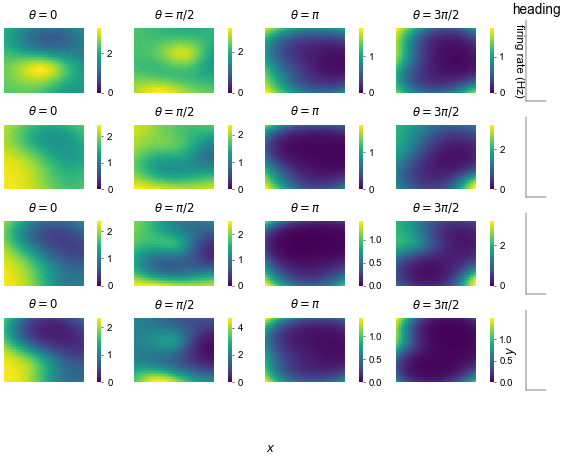

In [669]:
# theta slice plot with different heading direction
fig = plt.figure(figsize=(10, 7))

# full tuning plot
SP = 500.
DR_array = [0., .5*np.pi, np.pi, 1.5*np.pi]
HD = 0.

widths = [1, 1, 1, 1, 0.2]
heights = [1, 1, 1, 1]
nrows = 4
ncols = 5
spec_ = fig.add_gridspec(ncols=ncols, nrows=nrows, width_ratios=widths,
                         height_ratios=heights, wspace=0.4)

# Place field
grid_size = [int(arena_width/10), int(arena_height/10)]
grid_shape = [[left_x, right_x], [bottom_y, top_y]]
grid_extent = (left_x, right_x, bottom_y, top_y)


for k, DR in enumerate(DR_array):
    TH = 0.
    def func(pos):
        prevshape = pos.shape[1:]
        x = pos[0].flatten()
        y = pos[1].flatten()
        covariates = (x, y, SP*np.ones_like(x), \
                      TH*np.ones_like(x), DR*np.ones_like(x), HD*np.ones_like(x))
        return glm_rate.eval_rate(covariates, [0])[0].reshape(*prevshape)

    (xx, yy), place_field = tools.compute_mesh(grid_size, grid_shape, func)

    ax = fig.add_subplot(spec_[k, 0])
    _, ax = vs.visualize_field_(place_field, grid_extent, ticktitle='', figax=(fig, ax))
    #tools.decorate_ax(ax, xlim=[left_x, right_x], ylim=[bottom_y, top_y])
    
    ax.set_title(r'$\theta=0$', fontsize=12, pad=10)

    TH = np.pi*0.5
    def func(pos):
        prevshape = pos.shape[1:]
        x = pos[0].flatten()
        y = pos[1].flatten()
        covariates = (x, y, SP*np.ones_like(x), \
                      TH*np.ones_like(x), DR*np.ones_like(x), HD*np.ones_like(x))
        return glm_rate.eval_rate(covariates, [0])[0].reshape(*prevshape)

    (xx, yy), place_field = tools.compute_mesh(grid_size, grid_shape, func)

    ax = fig.add_subplot(spec_[k, 1])
    _, ax = vs.visualize_field_(place_field, grid_extent, ticktitle='', figax=(fig, ax))
    #tools.decorate_ax(ax, xlim=[left_x, right_x], ylim=[bottom_y, top_y])
    ax.set_title(r'$\theta=\pi/2$', fontsize=12, pad=10)

    TH = np.pi
    def func(pos):
        prevshape = pos.shape[1:]
        x = pos[0].flatten()
        y = pos[1].flatten()
        covariates = (x, y, SP*np.ones_like(x), \
                      TH*np.ones_like(x), DR*np.ones_like(x), HD*np.ones_like(x))
        return glm_rate.eval_rate(covariates, [0])[0].reshape(*prevshape)

    (xx, yy), place_field = tools.compute_mesh(grid_size, grid_shape, func)

    ax = fig.add_subplot(spec_[k, 2])
    _, ax = vs.visualize_field_(place_field, grid_extent, ticktitle='', figax=(fig, ax))
    #tools.decorate_ax(ax, xlim=[left_x, right_x], ylim=[bottom_y, top_y])
    ax.set_title(r'$\theta=\pi$', fontsize=12, pad=10)

    TH = np.pi*1.5
    def func(pos):
        prevshape = pos.shape[1:]
        x = pos[0].flatten()
        y = pos[1].flatten()
        covariates = (x, y, SP*np.ones_like(x), \
                      TH*np.ones_like(x), DR*np.ones_like(x), HD*np.ones_like(x))
        return glm_rate.eval_rate(covariates, [0])[0].reshape(*prevshape)

    (xx, yy), place_field = tools.compute_mesh(grid_size, grid_shape, func)

    ax = fig.add_subplot(spec_[k, 3])
    if k == 0:
        ticktitle = 'firing rate (Hz)'
    else:
        ticktitle = ''
    _, ax = vs.visualize_field_(place_field, grid_extent, ticktitle=ticktitle, figax=(fig, ax))
    #tools.decorate_ax(ax, xlim=[left_x, right_x], ylim=[bottom_y, top_y])
    ax.set_title(r'$\theta=3\pi/2$', fontsize=12, pad=10)

    ax = fig.add_subplot(spec_[k, 4])
    if k == 0:
        ax.set_title('heading')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.arrow(-2*np.cos(np.pi*k/2), -2*np.sin(np.pi*k/2), 4*np.cos(np.pi*k/2), 4*np.sin(np.pi*k/2), color='w', 
         width=1.0, head_width=2.8, head_length=3.0, alpha=0.5)

ax.set_ylabel(r'$y$')
fig.text(0.5, 0.0, r'$x$', transform=fig.transFigure, fontsize=12)
fig.subplots_adjust(wspace=0.2)

#plt.savefig('output/theta_slice.svg')
#plt.savefig('output/theta_slice.pdf')
plt.show()

In [125]:
# correlation between l_theta and theta index
corr, (freq, fourierTransform), theta_period, theta_index = neural_utils.theta_CCG(sample_bin, sep_t_spike[:50], track_samples, dev=dev)

0.020399599681253933
0.8881756081842602


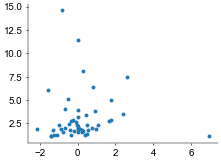

In [134]:
plt.scatter(np.log(toroidal[:, 0]), theta_index)
r, r_p = scstats.pearsonr(np.log(toroidal[:, 0]), theta_index)
print(r)
print(r_p)

0


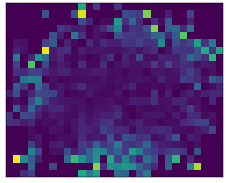

1


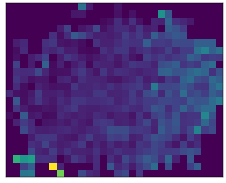

2


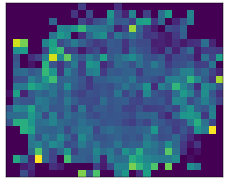

3


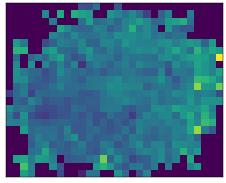

4


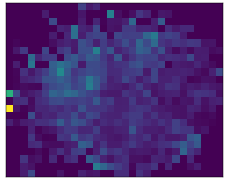

5


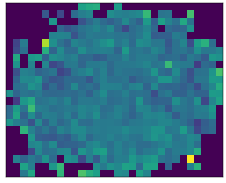

6


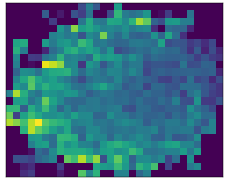

7


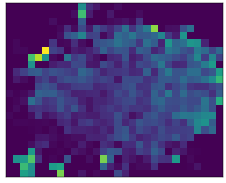

8


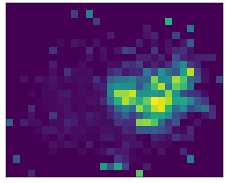

9


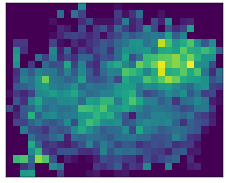

10


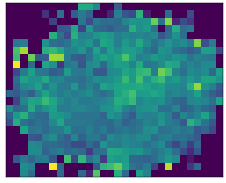

11


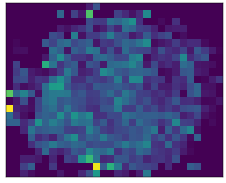

12


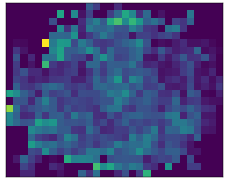

13


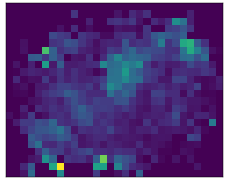

14


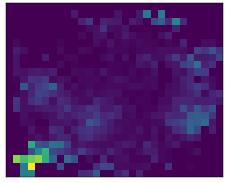

15


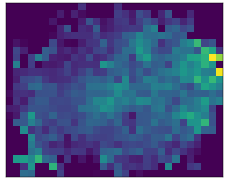

16


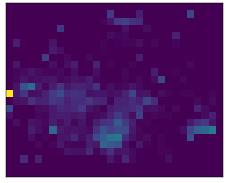

17


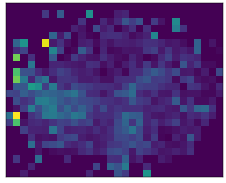

18


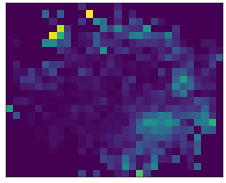

19


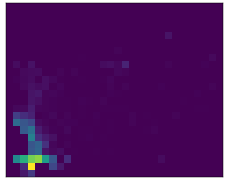

20


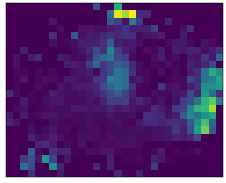

21


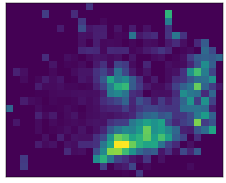

22


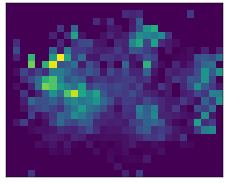

23


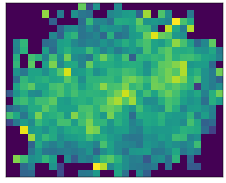

24


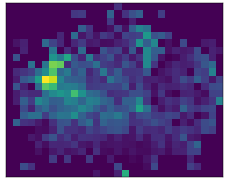

25


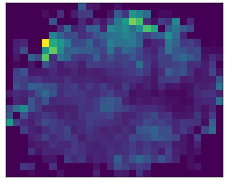

26


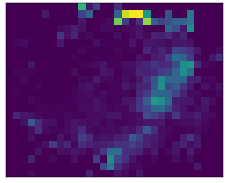

27


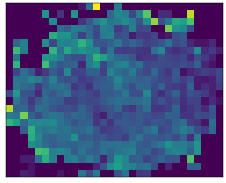

28


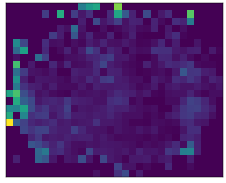

29


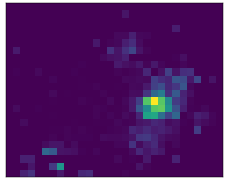

30


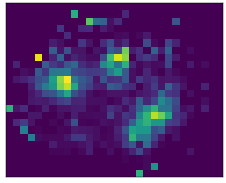

31


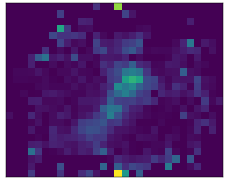

32


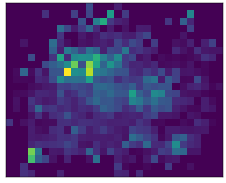

33


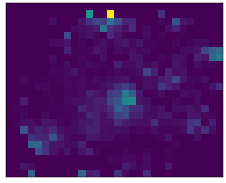

34


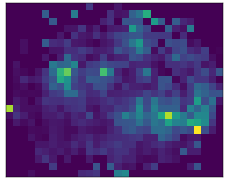

35


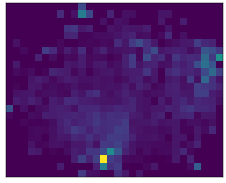

In [38]:
for unit in range(units_used):

    print(unit)
    fig, ax, im = tools.draw_2d(np.transpose(sp_rate[unit_used[unit]]), origin='lower', aspect='equal', 
                            cmap='viridis', vmax=sp_rate[unit_used[unit]].max())
    tools.decorate_ax(ax)
    plt.show()


### Theta model with field size

In [43]:
# Data
unit = [8]#, 40, 50]
units = len(unit)
behav_tuple = (x_t, y_t, wrap_theta_t)
t_spike = [used_t_spike[u] for u in unit]

bin_size = 1
tbin, _, rc_t, _ = neural_utils.BinTrain(bin_size, sample_bin, t_spike, track_samples)

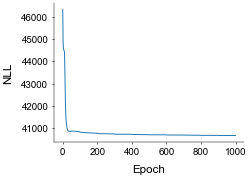

In [47]:
# GP theta model fit
num_induc = 32
inducing_points = np.array([left_x + arena_width*np.random.rand(num_induc), \
                            bottom_y + arena_height*np.random.rand(num_induc), \
                            np.random.rand(num_induc)*2*np.pi]).T

units_ = 1
l = np.ones(units_)
v = np.ones(units_)
glm_rate = mdl.nonparametrics.GP_covariates(units, inducing_points, \
                                            [('RBF', np.array([l, l]), v), ('torus_Cos', np.array([l]), v)],
                                            None, None, link='exp')
glm_rate.set_params(sample_bin)

shape = np.ones(units)
renewal_dist = mdl.renewal.Gamma(units, 'exp', shape)
renewal_dist.set_params(sample_bin)

glm = mdl.inference.nll_optimized(glm_rate, renewal_dist)
glm.preprocess(tuple(b[:] for b in behav_tuple), None, rc_t[:, :], batch_size=100000)
glm.to(dev)


# fit
sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.9)
opt_tuple = (optim.Adam, 100, sch)
opt_lr_dict = {'default': 1e-2}
glm.set_optimizers(opt_tuple, opt_lr_dict)

annealing = lambda x: min(1.0, 0.01*x)
losses = glm.fit(1000, margin=1e0, premature=100, anneal_func=annealing, cov_samples=1)

plt.figure()
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('NLL')
plt.show()

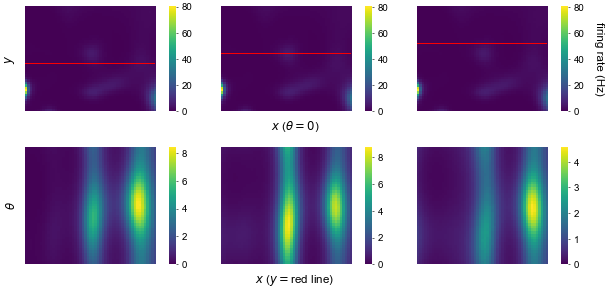

In [49]:
# show fits
neuron = [0]
fig, axes = plt.subplots(2, 3, figsize=(10,5))

grid_size = (int(arena_width/10), int(arena_height/10))
grid_shape = [[left_x, right_x], [bottom_y, top_y]]

TH = 0

for k in range(3):
    if k == 2:
        ticktitle='firing rate (Hz)'
    else:
        ticktitle=''

    def func(pos):
        prevshape = pos.shape[1:]
        x = pos[0].flatten()
        y = pos[1].flatten()
        covariates = (x, y, TH*np.ones_like(x))
        return glm_rate.eval_rate(covariates, [neuron])[0].reshape(*prevshape)

    mshtpl = tools.compute_mesh(grid_size, grid_shape, func)
    _, ax = vs.visualize_field(mshtpl[1], grid_shape, ticktitle=ticktitle, figax=(fig, axes[0][k]))
    x = np.linspace(left_x, right_x, 10)
    ax.plot(x, np.ones_like(x)*(40*k+200), color='r')
    
    if k == 0:
        ax.set_ylabel(r'$y$')

#grid_size = (int(arena_width/10), int(60))
grid_shape = [[left_x, right_x], [0, 2*np.pi]]

ticktitle = ''
for k in range(3):
    def func(pos):
        prevshape = pos.shape[1:]
        x = pos[0].flatten()
        y = (40*k+200)*np.ones(len(x))
        theta = pos[1].flatten()
        covariates = (x, y, theta)
        return glm_rate.eval_rate(covariates, [neuron])[0].reshape(*prevshape)

    mshtpl = tools.compute_mesh(grid_size, grid_shape, func)
    _, ax = vs.visualize_field(mshtpl[1], grid_shape, ticktitle=ticktitle, figax=(fig, axes[1][k]), aspect='auto')
    
    if k == 0:
        ax.set_ylabel(r'$\theta$')

fig.subplots_adjust(hspace=0.25, wspace=0.3)
fig.text(0.51, 0.08, r'$x$ ($y=$red line)', ha='center', va='center', fontsize=12)
fig.text(0.51, 0.52, r'$x$ ($\theta=0$)', ha='center', va='center', fontsize=12)

#plt.savefig('output/gp_theta.svg')
#plt.savefig('output/gp_theta.pdf')
plt.show()

In [54]:
# theta field size
grid_size = [int(arena_width/10), int(arena_height/10)]
grid_shape = [[left_x, right_x], [bottom_y, top_y]]


def compute_area(place_field, dx, dy, threshold=5.0):
    r"""
    Computes the are of the place field above some threshold (Hz).
    """
    bins = (place_field > threshold).sum()
    return bins*dx*dy

TH = 0.
def func(pos):
    prevshape = pos.shape[1:]
    x = pos[0].flatten()
    y = pos[1].flatten()
    covariates = (x, y, TH*np.ones_like(x))
    return glm_rate.eval_rate(covariates, [0])[0].reshape(*prevshape)

(xx, yy), place_field = tools.compute_mesh(grid_size, grid_shape, func)

dx = xx[0, 1]-xx[0, 0]
dy = yy[1, 0]-yy[0, 0]
print(compute_area(place_field, dx, dy))



TH = np.pi*0.5
def func(pos):
    prevshape = pos.shape[1:]
    x = pos[0].flatten()
    y = pos[1].flatten()
    covariates = (x, y, TH*np.ones_like(x))
    return glm_rate.eval_rate(covariates, [0])[0].reshape(*prevshape)

(xx, yy), place_field = tools.compute_mesh(grid_size, grid_shape, func)
dx = xx[0, 1]-xx[0, 0]
dy = yy[1, 0]-yy[0, 0]
print(compute_area(place_field, dx, dy))

TH = np.pi
def func(pos):
    prevshape = pos.shape[1:]
    x = pos[0].flatten()
    y = pos[1].flatten()
    covariates = (x, y, TH*np.ones_like(x))
    return glm_rate.eval_rate(covariates, [0])[0].reshape(*prevshape)

(xx, yy), place_field = tools.compute_mesh(grid_size, grid_shape, func)
dx = xx[0, 1]-xx[0, 0]
dy = yy[1, 0]-yy[0, 0]
print(compute_area(place_field, dx, dy))

TH = np.pi*1.5
def func(pos):
    prevshape = pos.shape[1:]
    x = pos[0].flatten()
    y = pos[1].flatten()
    covariates = (x, y, TH*np.ones_like(x))
    return glm_rate.eval_rate(covariates, [0])[0].reshape(*prevshape)

(xx, yy), place_field = tools.compute_mesh(grid_size, grid_shape, func)
dx = xx[0, 1]-xx[0, 0]
dy = yy[1, 0]-yy[0, 0]
print(compute_area(place_field, dx, dy))

11830.349980217718
22381.743205817304
27817.30941294436
11617.190521114695


In [ ]:
# theta field size
fig = plt.figure(figsize=(10, 7))

# full tuning plot
widths = [1, 1, 1, 1, 0.2]
heights = [1, 1, 1, 1]
nrows = 4
ncols = 5
spec_ = fig.add_gridspec(ncols=ncols, nrows=nrows, width_ratios=widths,
                         height_ratios=heights, wspace=0.4)

# Place field
grid_size = [int(arena_width/10), int(arena_height/10)]
grid_shape = [[left_x, right_x], [bottom_y, top_y]]
grid_extent = (left_x, right_x, bottom_y, top_y)


for k, DR in enumerate(DR_array):
    TH = 0.
    def func(pos):
        prevshape = pos.shape[1:]
        x = pos[0].flatten()
        y = pos[1].flatten()
        covariates = (x, y, SP*np.ones_like(x), \
                      TH*np.ones_like(x), DR*np.ones_like(x), HD*np.ones_like(x))
        return glm_rate.eval_rate(covariates, [0])[0].reshape(*prevshape)

    (xx, yy), place_field = tools.compute_mesh(grid_size, grid_shape, func)

    ax = fig.add_subplot(spec_[k, 0])
    _, ax = vs.visualize_field_(place_field, grid_extent, ticktitle='', figax=(fig, ax))
    #tools.decorate_ax(ax, xlim=[left_x, right_x], ylim=[bottom_y, top_y])
    
    ax.set_title(r'$\theta=0$', fontsize=12, pad=10)

    TH = np.pi*0.5
    def func(pos):
        prevshape = pos.shape[1:]
        x = pos[0].flatten()
        y = pos[1].flatten()
        covariates = (x, y, SP*np.ones_like(x), \
                      TH*np.ones_like(x), DR*np.ones_like(x), HD*np.ones_like(x))
        return glm_rate.eval_rate(covariates, [0])[0].reshape(*prevshape)

    (xx, yy), place_field = tools.compute_mesh(grid_size, grid_shape, func)

    ax = fig.add_subplot(spec_[k, 1])
    _, ax = vs.visualize_field_(place_field, grid_extent, ticktitle='', figax=(fig, ax))
    #tools.decorate_ax(ax, xlim=[left_x, right_x], ylim=[bottom_y, top_y])
    ax.set_title(r'$\theta=\pi/2$', fontsize=12, pad=10)

    TH = np.pi
    def func(pos):
        prevshape = pos.shape[1:]
        x = pos[0].flatten()
        y = pos[1].flatten()
        covariates = (x, y, SP*np.ones_like(x), \
                      TH*np.ones_like(x), DR*np.ones_like(x), HD*np.ones_like(x))
        return glm_rate.eval_rate(covariates, [0])[0].reshape(*prevshape)

    (xx, yy), place_field = tools.compute_mesh(grid_size, grid_shape, func)

    ax = fig.add_subplot(spec_[k, 2])
    _, ax = vs.visualize_field_(place_field, grid_extent, ticktitle='', figax=(fig, ax))
    #tools.decorate_ax(ax, xlim=[left_x, right_x], ylim=[bottom_y, top_y])
    ax.set_title(r'$\theta=\pi$', fontsize=12, pad=10)

    TH = np.pi*1.5
    def func(pos):
        prevshape = pos.shape[1:]
        x = pos[0].flatten()
        y = pos[1].flatten()
        covariates = (x, y, SP*np.ones_like(x), \
                      TH*np.ones_like(x), DR*np.ones_like(x), HD*np.ones_like(x))
        return glm_rate.eval_rate(covariates, [0])[0].reshape(*prevshape)

    (xx, yy), place_field = tools.compute_mesh(grid_size, grid_shape, func)

    ax = fig.add_subplot(spec_[k, 3])
    if k == 0:
        ticktitle = 'firing rate (Hz)'
    else:
        ticktitle = ''
    _, ax = vs.visualize_field_(place_field, grid_extent, ticktitle=ticktitle, figax=(fig, ax))
    #tools.decorate_ax(ax, xlim=[left_x, right_x], ylim=[bottom_y, top_y])
    ax.set_title(r'$\theta=3\pi/2$', fontsize=12, pad=10)

    ax = fig.add_subplot(spec_[k, 4])
    if k == 0:
        ax.set_title('heading')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.arrow(-2*np.cos(np.pi*k/2), -2*np.sin(np.pi*k/2), 4*np.cos(np.pi*k/2), 4*np.sin(np.pi*k/2), color='w', 
         width=1.0, head_width=2.8, head_length=3.0, alpha=0.5)

ax.set_ylabel(r'$y$')
fig.text(0.5, 0.0, r'$x$', transform=fig.transFigure, fontsize=12)
fig.subplots_adjust(wspace=0.2)

#plt.savefig('output/theta_slice.svg')
#plt.savefig('output/theta_slice.pdf')
plt.show()